In [36]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

# from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#MNIST
(patches, _), (test_patches, _) = tf.keras.datasets.mnist.load_data()
eigenvalue_floor = 1e0


In [42]:
from encoding_information.bsccm_utils import *
from encoding_information.image_utils import *

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

# load images, extract patches, and compute cov mats
edge_crop = 24
patch_size = 28
num_images = 20000
num_images = 5000

channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 500

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 5000
seed = 10

patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


Opening BSCCM
Opened BSCCM


In [43]:
from encoding_information.models.gaussian_process import StationaryGaussianProcess

stationary_gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = stationary_gp.fit(patches, max_epochs=5, eigenvalue_floor=eigenvalue_floor)          

Computing loss: 8it [00:01,  6.41it/s]


Initial validation NLL: 5941.67


Epoch 1: 100%|██████████| 1/1 [00:27<00:00, 27.45s/it]
Computing loss: 8it [00:00, 16.67it/s]


Epoch 1: validation NLL: 4.53


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
Computing loss: 8it [00:00, 16.27it/s]


Epoch 2: validation NLL: 4.43


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
Computing loss: 8it [00:00, 16.39it/s]


Epoch 3: validation NLL: 4.43


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
Computing loss: 8it [00:00, 16.13it/s]


Epoch 4: validation NLL: 4.42


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
Computing loss: 8it [00:00, 16.31it/s]

Epoch 5: validation NLL: 4.42


In [44]:
from encoding_information.models.pixel_cnn import PixelCNN

num_hidden_channels = 64
num_mixture_components = 40

pixel_cnn = PixelCNN(num_hidden_channels=num_hidden_channels, num_mixture_components=num_mixture_components)
pixel_cnn.fit(patches, max_epochs=30)          


Computing loss: 15it [00:01, 12.00it/s]


Initial validation NLL: 119.51


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]
Computing loss: 15it [00:00, 78.09it/s]


Epoch 1: validation NLL: 5.13


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 31.02it/s]
Computing loss: 15it [00:00, 79.09it/s]


Epoch 2: validation NLL: 5.31


Epoch 3:  31%|███       | 31/100 [00:01<00:02, 31.02it/s]

## Compare test set likelihood and samples from both models

In [ ]:
stationary_gp_nll = stationary_gp.compute_negative_log_likelihood(test_patches)
pixel_cnn_nll = pixel_cnn.compute_negative_log_likelihood(test_patches)
print(f"Stationary GP NLL: {stationary_gp_nll}")
print(f"PixelCNN NLL: {pixel_cnn_nll}")

precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 200.21it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 194.88it/s]


Stationary GP NLL: 4.543676951938966
PixelCNN NLL: 4.518189179015043


In [ ]:
num_samples = 8

gp_samples = stationary_gp.generate_samples(num_samples)
pixel_cnn_samples = pixel_cnn.generate_samples(num_samples)

Generating samples:   0%|          | 0/10 [00:00<?, ?it/s]2023-10-21 15:41:22.749478: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-21 15:41:22.749506: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
Generating samples:  20%|██        | 2/10 [00:10<00:43,  5.42s/it]


KeyboardInterrupt: 

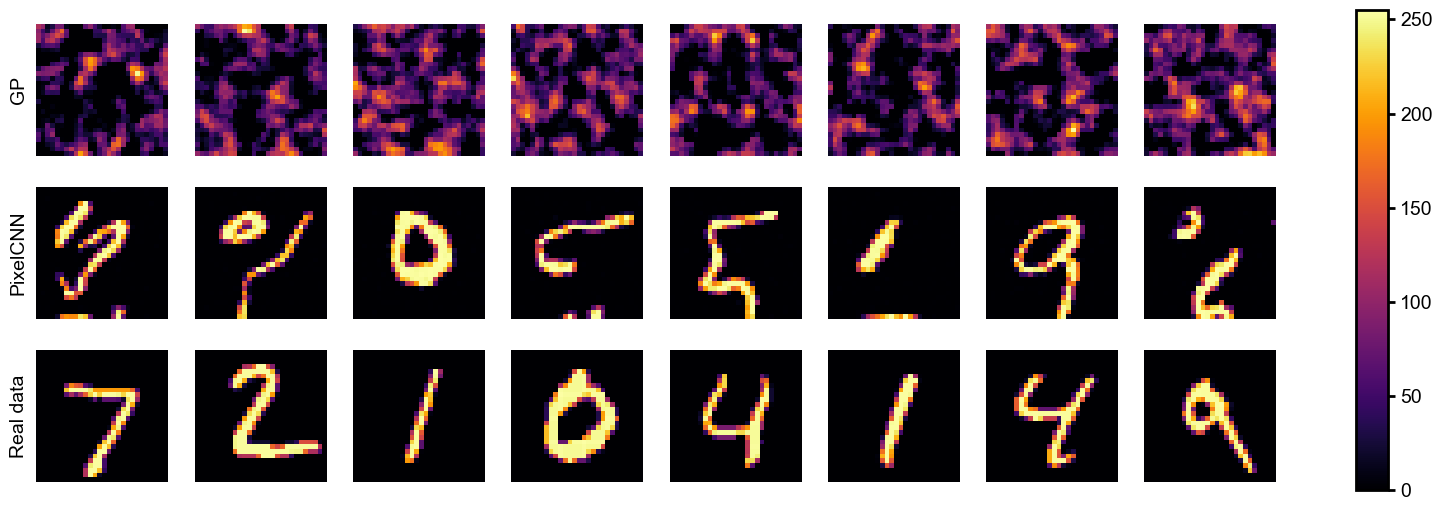

In [ ]:
# plot samples
fig, axes = plt.subplots(3, len(gp_samples), figsize=(2 * len(gp_samples), 6))

vmin, vmax = np.percentile(patches, 0.1), np.percentile(patches, 99.9)
# vmin, vmax = np.percentile(gp_samples, 0.5), np.percentile(gp_samples, 99.5)

for i, (gp_sample, pixel_cnn_sample) in enumerate(zip(gp_samples, pixel_cnn_samples)):
    axes[0, i].imshow(gp_sample, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[1, i].imshow(pixel_cnn_sample, cmap='inferno', vmin=vmin, vmax=vmax)
    im = axes[2, i].imshow(test_patches[i], cmap='inferno', vmin=vmin, vmax=vmax)
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')

# add colorbar
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax)

# add text to the left side of each row
for i, label in enumerate(['GP', 'PixelCNN', 'Real data']):
    axes[i, 0].text(-0.2, 0.5, label, transform=axes[i, 0].transAxes, va='center', rotation='vertical', fontsize=14)